# tensorflow highlevel api after 1.3 part 1 summary

## resources
- [higher-level apis in tensorflow](https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0)
- [example of tensorflows new input pipeline](https://kratzert.github.io/2017/06/15/example-of-tensorflows-new-input-pipeline.html)
- [introduction to tensorflow datasets and estimators](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)
- [cloudml census example](https://github.com/GoogleCloudPlatform/cloudml-samples/tree/master/census/customestimator/trainer)
- [using tensorflow api for structured data - another census example](https://github.com/tensorflow/workshops/blob/master/notebooks/07_structured_data.ipynb)
- [Example of TensorFlows new Input Pipeline](https://kratzert.github.io/2017/06/15/example-of-tensorflows-new-input-pipeline.html)
- [Finetune AlexNet with Tensorflow](https://github.com/kratzert/finetune_alexnet_with_tensorflow)
- [programmer's guide - dataset](https://www.tensorflow.org/programmers_guide/datasets)
- [programmer's guide - estimators](https://www.tensorflow.org/programmers_guide/estimators)
- [api docs: feature_column](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/feature_column)
- [wide and deep learning tutorial](https://www.tensorflow.org/tutorials/wide_and_deep)

In [52]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Part 1 Summary

### high level components and structure  - from [higher-level apis in tensorflow](https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0)

<img src="https://cdn-images-1.medium.com/max/1600/1*zoNZvvuJb06yAghetc6BfQ.png">

In one sentence, the whole idea is to try to write everything in tensorflow itself!

## Part 2 dataset

A Dataset is a collection of elements, each with the same structure, where one element can be one of more tensors. The different tensors inside an element are called components. Each component has a certain data type and shape, but different components inside one element can have different data types and shapes.

### dataset construction
- from source, e.g., memory (placeholder, constant tensor and etc), hard disk (tfrecord, images, text files)
- from transformation

### main interface
- iterator (one-shot, initializable, reinitailizable, feedable)

### estimator needs a input_fn that returns a two-element tuptle organized as follows:
- The first element must be a dict in which each input feature is a key, and then a list of values for the training batch.
- The second element is a list of labels for the training batch.
For example,


```python
def input_fn():
    ...<code>...
    return ({ 'SepalLength':[values], ..<etc>.., 'PetalWidth':[values] },
            [IrisFlowerType])
```

### useful packages
- tf decoder, e.g., `tf.decode_csv`, parsing data into tensors
- tf dataset from source, e.g., `tf.TextLineDataset`
- main transformation:
    - `map`
    - `shuffle`
    - `batch`

In [4]:
import tensorflow as tf
tf.__version__

'1.3.0'

### 2.1 Dataset CSV Example
- use `data.TextLineDataset` interface
- iris data
    - train: http://download.tensorflow.org/data/iris_training.csv
    - test: http://download.tensorflow.org/data/iris_test.csv
- sometime you might want to just use the pandas input function:
    - `estimator.inputs.pandas_input_fn`
    - but using a dataset api has a nicer interface and scales better

In [14]:
from tensorflow.contrib import data # might move to core later 

# define the input function for estimator/experiment - factory method
# use tf Dataset api, with text line data source


def iris_input_fn(file_path, perform_shuffle=False, repeat_count=1):
    """input_fn returns access iterator to a dataset
    """
    feature_names = ["sepallength", "sepalwidth", "petallength", "petalwidth"]
    def decode_csv(line):
        # parsed as tensors
        # default values also define the dtype
        parsed_line = tf.decode_csv(line, [[0.], [0.], [0.], [0.], [0]])
        label = parsed_line[-1:] # list of the last element as label
        features = parsed_line[:-1]
        # return tuple of (feature_dict, label_list)
        return (dict(zip(feature_names, features)), label)
    dataset = (data.TextLineDataset(file_path)
                   .skip(1) # skip header
                   .map(decode_csv, 
                        num_threads=4, # running in parallel
                        output_buffer_size=100*32)) # transform each line to a tuple
    if perform_shuffle:
        # randomize input using a window of 256 in memory, should be bigger than batch?
        dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count) # repeat dataset # times
    dataset = dataset.batch(32) # batch to use
    # main interface as an iterator
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels

In [4]:
x_batch, y_batch = iris_input_fn("../../data/iris/iris_training.csv")
x_batch, y_batch

({'petallength': <tf.Tensor 'IteratorGetNext:0' shape=(?,) dtype=float32>,
  'petalwidth': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=float32>,
  'sepallength': <tf.Tensor 'IteratorGetNext:2' shape=(?,) dtype=float32>,
  'sepalwidth': <tf.Tensor 'IteratorGetNext:3' shape=(?,) dtype=float32>},
 <tf.Tensor 'IteratorGetNext:4' shape=(?, 1) dtype=int32>)

In [7]:
with tf.Session() as sess:
    print(sess.run(y_batch).shape)

(32, 1)


### 2.2 Dataset from Memory
- for small dataset that can be fit into the memory

In [12]:
# array in memories
prediction_input = [[5.9, 3.0, 4.2, 1.5],  # -> 1, Iris Versicolor
                    [6.9, 3.1, 5.4, 2.1],  # -> 2, Iris Virginica
                    [5.1, 3.3, 1.7, 0.5]]  # -> 0, Iris Sentosa

def memory_input_fn():
    # data meta information should probably be defined globally after so many redundance
    feature_names = ["sepallength", "sepalwidth", "petallength", "petalwidth"]
    def decode(row):
        # always use the tf version, because it spits out tensors
        feats = tf.split(row, 4)
        # don't need the label when predicting
        return dict(zip(feature_names, feats))
    # use a memory structure as input
    dataset = (data.Dataset.from_tensor_slices(prediction_input)
                           .map(decode))
    iterator = dataset.make_one_shot_iterator()
    batch_x = iterator.get_next()
    # you still need the tuple for data pipeline
    return batch_x, None


### 2.3 Dataset for images
- notes for this example is mainly from [this article](https://kratzert.github.io/2017/06/15/example-of-tensorflows-new-input-pipeline.html)
- some practice on how to deal with image data, e.g., using image path and labels from memory

In [37]:
train_imgs = tf.constant(['train/img1.png', 'train/img2.png', 'train/img3.png'])
train_labels = tf.constant([0, 0, 1])

train_data = data.Dataset.from_tensor_slices( (train_imgs, train_labels) )
train_iter = train_data.make_one_shot_iterator()
img_batch, img_label = train_iter.get_next()

with tf.Session() as sess:
    while True:
        try:
            imgs, labels = sess.run([img_batch, img_label])
            print(imgs, labels)
        except tf.errors.OutOfRangeError:
            print("end of training dataset")
            break

b'train/img1.png' 0
b'train/img2.png' 0
b'train/img3.png' 1
end of training dataset


In [5]:
!ls ../../data/images/

llama.jpeg   sealion.jpeg zebra.jpeg


In [48]:
# a complete example
train_images = tf.gfile.Glob("../../data/images/*")
train_labels = tf.constant([0, 0, 1]) # faked labels

IMAGENET_MEAN = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32)

def parse_img_label(img_files, labels):
    # image operations
    img_str = tf.read_file(img_files)
    img_decoded = tf.image.decode_jpeg(img_str, channels=3, )
    img_resized = tf.image.resize_images(img_decoded, [227, 227], )
    img_centered = img_resized
#     img_centered = tf.subtract(img_resized, IMAGENET_MEAN)
    # label operations
    one_hot = tf.one_hot(labels, 2)
    return (img_centered, one_hot)

# the input to `from_tensor_slices` must be a TUPLE, than a list
train_data = data.Dataset.from_tensor_slices( (train_images, train_labels) )
train_data = train_data.map(parse_img_label).batch(2).repeat(1).shuffle(2*5)
train_iter = train_data.make_one_shot_iterator()
img_batch, label_batch = train_iter.get_next()

(1, 227, 227, 3) (1, 2)
(2, 227, 227, 3) (2, 2)
end of dataset


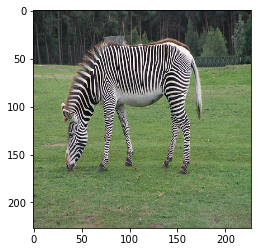

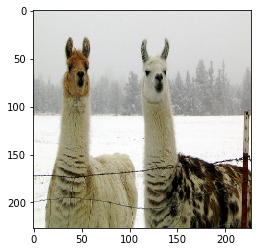

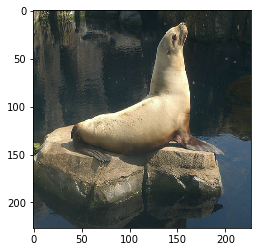

In [53]:
with tf.Session() as sess:
    while True:
        try:
            imgs, labels = sess.run([img_batch, label_batch])
            print(imgs.shape, labels.shape)
            for img in imgs:
                plt.figure()
                plt.imshow(img.astype(np.uint8))
        except tf.errors.OutOfRangeError:
            print("end of dataset")
            break

## Part 3 estimator
- the most important interface to an estimator is the data pipe, defined as `input_fn`
- `input_fn`
    - takes no parameters
    - always return `(batch_x, batch_y)`, where both are tensors
    - usually it returns the result of `data_iterator.get_next()`, where `data_iterator` is the iterator interface to a dataset
- for an estimator to use a data pipe, you need to provide the "adaptor" between them, which is defined as `feature_columns` parameter. It is essentially an adaptor from original features to transformed features

In [13]:
from tensorflow import estimator
from functools import partial

In [14]:
# estimiator definition starts with meta-data definition, e.g. columns
feature_names = ["sepallength", "sepalwidth", "petallength", "petalwidth"]
feature_columns = [tf.feature_column.numeric_column(f) for f in feature_names]

# use a predefined model
# subsequent run will try to load the model from model_dir,
# remove it if you want a fresh run
classifier = estimator.DNNClassifier(
    hidden_units=[10, 10], 
    feature_columns=feature_columns, 
    model_dir="../../models/iris/", 
    n_classes=3)

# train the model on the input pipe
# it takes a function as parameter, because it may need to recreate 
# the tensors sometime, estimators need input_fn with no argument
train_path = "../../data/iris/iris_training.csv"
classifier.train(input_fn=partial(iris_input_fn, file_path=train_path, perform_shuffle=True, repeat_count=8))

# evaluate on validation set
test_path = "../../data/iris/iris_test.csv"
eval_results = classifier.evaluate(input_fn=lambda : iris_input_fn(test_path, perform_shuffle=False, repeat_count=1))
for key in eval_results:
    print("{} : {}".format(key, eval_results[key]))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../../models/iris/', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../../models/iris/model.ckpt-30
INFO:tensorflow:Saving checkpoints for 31 into ../../models/iris/model.ckpt.
INFO:tensorflow:loss = 11.7159, step = 31
INFO:tensorflow:Saving checkpoints for 60 into ../../models/iris/model.ckpt.
INFO:tensorflow:Loss for final step: 5.59329.
INFO:tensorflow:Starting evaluation at 2017-10-23-01:35:48
INFO:tensorflow:Restoring parameters from ../../models/iris/model.ckpt-60
INFO:tensorflow:Finished evaluation at 2017-10-23-01:35:49
INFO:tensorflow:Saving dict for global step 60: accuracy = 0.966667, average_loss = 0.245982, global_step 

In [15]:
## make predictions, reading from files on disk
pred_results = classifier.predict(input_fn=lambda: iris_input_fn(test_path, perform_shuffle=False, repeat_count=1))
for pred in pred_results:
    print(pred)
    break

INFO:tensorflow:Restoring parameters from ../../models/iris/model.ckpt-60
{'logits': array([-0.77749223,  2.64866757,  1.10936403], dtype=float32), 'probabilities': array([ 0.02607093,  0.80189759,  0.17203146], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object)}


In [16]:
## prediction with data pipe on memory values
pred_results = classifier.predict(input_fn=memory_input_fn)
for pred_result in pred_results:
    print(pred_result)

INFO:tensorflow:Restoring parameters from ../../models/iris/model.ckpt-60
{'logits': array([-0.77749252,  2.64866734,  1.10936427], dtype=float32), 'probabilities': array([ 0.02607093,  0.80189747,  0.17203151], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object)}
{'logits': array([-2.55795479,  3.51808071,  3.66817307], dtype=float32), 'probabilities': array([ 0.00106147,  0.46205625,  0.53688234], dtype=float32), 'class_ids': array([2]), 'classes': array([b'2'], dtype=object)}
{'logits': array([ 4.37630939,  1.15077615, -4.09433651], dtype=float32), 'probabilities': array([  9.61590052e-01,   3.82083841e-02,   2.01481496e-04], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object)}


## Part 4 experiment

## Part 5 some utility function
- `tf.app` - argumentparser, main function
- `tf.gfile` - shutil, os, glob and etc
- `tf.logging`

In [17]:
import tensorflow as tf

### usage of `tf.app`

In [18]:
## set and get and command line parameters
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string(flag_name='saved_model_dir',
                           default_value='./models',
                           docstring='Output dir for model and training sets')
# later access it by
FLAGS.saved_model_dir

'./models'

In [19]:
## run the main function
def main_fn(argv=None):
    pass

if __name__ == "__main__":
    tf.app.run(main=main_fn, argv=None)

SystemExit: 

/Users/pmal252d/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### usage of `tf.gfile`

In [10]:
tf.gfile.Exists
tf.gfile.IsDirectory
tf.gfile.Glob
tf.gfile.GFile
tf.gfile.DeleteRecursively

<function tensorflow.python.lib.io.file_io.delete_recursively>

### usage of tf.logging

In [38]:
tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.warn("on logging")

### usage of tf.image

In [42]:
tf.read_file # tensor version
tf.image.decode_image
tf.image.resize_images

<function tensorflow.python.ops.image_ops_impl.resize_images>

## Example 1: adult census data
- pipeline for feature transformation using census data
- tensorflow for structured data
- the values in the csv always starts with an extra whitespace
- get the data
    - train: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
    - test: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
    
    
### Notes
- to build solution you need `data` and `model`
- `data` is defined as a pipe
    - in the format of `input_fn()`, which will return a tuple of batch every time when it is called
    - it is usually implemented by data api, with the call of iterator.get_next()
- `model` is defined in
    - `model_fn` that returns `EstimatorSpec`, defining computation graph and how to run TRAIN/EVAL/PREDICT
    - `input_fn` that is used for train/eval/predict, to provide original data
    - `feature_columns` that glue/transform model with data pipe

### step 1 use pandas to explore the data

In [20]:
import pandas as pd
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'gender',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

df = pd.read_csv("../../data/adult/adult.data", names=column_names)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### step 2 build data pipe with dataset api
- the output is the `input_fn` for an estimator
- use dataset api might have more pros compared to directly reading from pandas
- common practice:
    - build the pipe with meta data (e.g., original feature names, default values), transformed feature columns with feature_column api
    - use data api to read from data source and pipe it with transformed columns

In [57]:
from tensorflow import estimator, feature_column
from tensorflow.contrib import data
from collections import OrderedDict

In [58]:
# it is usually good practice to start with original data name and default values (and thus dtype), 
# as the schema of the data - order is important

csv_column_defaults = OrderedDict([
    ('age', [0]),
    ('workclass', ['']),
    ('fnlwgt', [0]),
    ('education', ['']),
    ('education-num', [0]),
    ('marital-status', ['']),
    ('occupation', ['']),
    ('relationship', ['']),
    ('race', ['']),
    ('gender', ['']),
    ('capital-gain', [0]),
    ('capital-loss', [0]),
    ('hours-per-week', [0]),
    ('native-country', ['']),
    ('income', [''])
])

In [73]:
## then we need to define the parser from the data source, i.e., csv in this case
## using dataset api

def csv_decoder(line):
    parsed = tf.decode_csv(line, list(csv_column_defaults.values())) # to tensors
    # return dict
    return dict(zip(csv_column_defaults.keys(), parsed))

# helper function
def filter_empty_lines(line):
    # always use tf operator, return true is line is empty
    return tf.not_equal(0, tf.size(tf.string_split([line], ', ').values))

# define train and test pipe (aka input_fn)
# every time the input_fn is called, it spits out a batch
def get_input_fn(path, ignore_lines=0, shuffle=False, repeats=1):
    def input_fn():
        # create dataset
        dataset = (data.TextLineDataset(path)
                   .skip(ignore_lines) # the first line in test file should be passed
                   .filter(filter_empty_lines)
                   .map(csv_decoder))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=200)
        dataset = dataset.repeat(repeats).batch(32)
        # create iterator and batch variables
        feats = dataset.make_one_shot_iterator().get_next()
        income = tf.equal(feats.pop('income'), " >50K")
        income = tf.cast(income, tf.int32)
        return (feats, income)
    return input_fn

## test the pipe
with tf.Session() as sess:
    train_input_fn = get_input_fn("../../data/adult/adult.data", shuffle=True, repeats=5)
    test_input_fn = get_input_fn("../../data/adult/adult.test", ignore_lines=1, shuffle=False, repeats=1)
    train_feats, train_income = sess.run(train_input_fn())
    test_feats, test_income = sess.run(test_input_fn())
    print(train_feats.keys(), test_feats.keys())
    print(train_income.shape, test_income.shape)

dict_keys(['age', 'capital-gain', 'capital-loss', 'education', 'education-num', 'fnlwgt', 'gender', 'hours-per-week', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'workclass']) dict_keys(['age', 'capital-gain', 'capital-loss', 'education', 'education-num', 'fnlwgt', 'gender', 'hours-per-week', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'workclass'])
(32,) (32,)


### setp 3 define adaptor between data pipe and estimiator using feature_column api
- common feature represenations by feature_column api
    - A numeric_column. This is just a real-valued attribute.
    - A bucketized_column. TensorFlow automatically buckets a numeric column for us.
    - A categorical_column_with_vocabulary_list. This is just a categorical column, where you know the possible values in advance. This is useful when you have a small number of possibilities.
    - A categorical_column_with_hash_bucket. This is a useful way to represent categorical features when you have a large number of values. Beware of hash collisions.
    - A crossed_column. Linear models cannot consider interactions between features, so we'll ask TensorFlow to cross features for us.
- common feature transformations:
    - feature_column.indicator_column
    - feature_column.embedding_column
- use `tf.feature_column.input_layer` to pipe the data into engineered features

In [60]:
hour_per_week = feature_column.numeric_column('hours-per-week')
education_num = feature_column.bucketized_column( # represented features
                    feature_column.numeric_column('education-num'), # raw feature
                    list(range(10)))
age_buckets = feature_column.bucketized_column(
                    feature_column.numeric_column('age'), 
                    boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
sex = feature_column.categorical_column_with_vocabulary_list('gender', ['male', 'female'])
native_country = feature_column.categorical_column_with_hash_bucket('native-country', 1000)
## a crossed column
education_num_x_gender = feature_column.crossed_column([education_num, sex], hash_bucket_size=int(1e4))

estimator_columns = [
    hour_per_week,
    education_num,
    age_buckets,
    feature_column.indicator_column(sex),
    feature_column.embedding_column(native_country, dimension=10),
    feature_column.embedding_column(education_num_x_gender, 20)
]

### step 4 test it with a predefined model

In [61]:
model_dir = "../../models/adult"
if tf.gfile.Exists(model_dir):
    tf.gfile.DeleteRecursively(model_dir)
    
classifier = estimator.DNNClassifier([64, 64], estimator_columns, 
                                     model_dir=model_dir, n_classes=2, optimizer="Adam")

train_input_fn = get_input_fn("../../data/adult/adult.data", shuffle=True, repeats=8)
test_input_fn = get_input_fn("../../data/adult/adult.test", ignore_lines=1, shuffle=False, repeats=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../../models/adult', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [27]:
%time classifier.train(input_fn=train_input_fn)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../../models/adult/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into ../../models/adult/model.ckpt.
INFO:tensorflow:loss = 225.036, step = 2
INFO:tensorflow:global_step/sec: 137.723
INFO:tensorflow:loss = 17.4396, step = 102 (0.727 sec)
INFO:tensorflow:global_step/sec: 140.526
INFO:tensorflow:loss = 14.3165, step = 202 (0.711 sec)
INFO:tensorflow:global_step/sec: 146.961
INFO:tensorflow:loss = 13.7932, step = 302 (0.681 sec)
INFO:tensorflow:global_step/sec: 144.768
INFO:tensorflow:loss = 17.5033, step = 402 (0.691 sec)
INFO:tensorflow:global_step/sec: 144.836
INFO:tensorflow:loss = 18.8871, step = 502 (0.691 sec)
INFO:tensorflow:global_step/sec: 136.422
INFO:tensorflow:loss = 15.8654, step = 602 (0.733 sec)
INFO:tensorflow:global_step/sec: 156.628
INFO:tensorflow:loss = 18.7329, step = 702 (0.638 sec)
INFO:tensorflow:global_step/sec: 150.632
INFO:tensorflow:loss = 17.514, step = 802 (0.664 se

In [28]:
%time eval_result = classifier.evaluate(test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-10-23-01:43:34
INFO:tensorflow:Restoring parameters from ../../models/adult/model.ckpt-8142
INFO:tensorflow:Finished evaluation at 2017-10-23-01:43:38
INFO:tensorflow:Saving dict for global step 8142: accuracy = 1.0, accuracy_baseline = 1.0, auc = 1.0, auc_precision_recall = 0.0, average_loss = 0.284434, global_step = 8142, label/mean = 0.0, loss = 9.09797, prediction/mean = 0.247475
CPU times: user 8.08 s, sys: 2.59 s, total: 10.7 s
Wall time: 6.95 s


In [29]:
for k, v in eval_result.items():
    print("{}: {}".format(k, v))

accuracy: 1.0
accuracy_baseline: 1.0
auc: 1.0
auc_precision_recall: 0.0
average_loss: 0.2844337522983551
label/mean: 0.0
loss: 9.097968101501465
prediction/mean: 0.24747467041015625
global_step: 8142


### step 5 use a customized estimator
- instead of using the feature_columns, define a customized `model_fn`

In [93]:
def model_fn(mode, features, labels):
    # the features, labels will be pumped from the input_fn pipe
    # define customized feature adaptor used for the model
    hour_per_week = feature_column.numeric_column('hours-per-week')
    education_num = feature_column.bucketized_column( # represented features
                        feature_column.numeric_column('education-num'), # raw feature
                        list(range(10)))
    age_buckets = feature_column.bucketized_column(
                        feature_column.numeric_column('age'), 
                        boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
    sex = feature_column.categorical_column_with_vocabulary_list('gender', ['male', 'female'])
    native_country = feature_column.categorical_column_with_hash_bucket('native-country', 1000)
    ## a crossed column
    education_num_x_gender = feature_column.crossed_column([education_num, sex], hash_bucket_size=int(1e4))

    feature_columns = [
        hour_per_week,
        education_num,
        age_buckets,
        feature_column.indicator_column(sex),
        feature_column.embedding_column(native_country, dimension=10),
        feature_column.embedding_column(education_num_x_gender, 20)
    ]
    # build the model
    inputs = tf.feature_column.input_layer(features, feature_columns)
    curr_layer = inputs
    for hidden_size in [64, 64]:
        curr_layer = tf.layers.dense(curr_layer, hidden_size, activation=tf.nn.elu,
                                     kernel_initializer=tf.variance_scaling_initializer())
    logits = tf.layers.dense(curr_layer, 2, activation=None, 
                      kernel_initializer=tf.variance_scaling_initializer())
    
    # get downstream predictions only for EVAL and PREDICT
    if mode in (estimator.ModeKeys.EVAL, estimator.ModeKeys.PREDICT):
        probabilities = tf.nn.softmax(logits)
        label_indices = tf.argmax(logits, axis=1)
    
    ## get loss only for TRAIN and EVAL
    if mode in (estimator.ModeKeys.TRAIN, estimator.ModeKeys.EVAL):
        # global_step is necessary in EVAL to correctly load the step of the checkpoint we are evaluating
        global_step = tf.contrib.framework.get_or_create_global_step()
        # loss
#         loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
        # housekeeping
        tf.summary.scalar('loss', loss)
        
    ## return different specs for different modes
    
    ## for PREDICT, only predictions are compulsory
    if mode == estimator.ModeKeys.PREDICT:
        predictions = {
            "classes": label_indices,
            "scores": tf.reduce_max(probabilities, axis=1)
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    ## for TRAIN, loss and train_op is compulsory (as well as global_step)
    if mode == estimator.ModeKeys.TRAIN:
        train_op = tf.train.AdamOptimizer().minimize(loss, global_step=global_step)
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    ## for EVAL: loss is compulsory (as well as global_step), eval_metric_ops is optional
    if mode == estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(labels, label_indices)
        }
        return tf.estimator.EstimatorSpec(mode, eval_metric_ops=eval_metric_ops, loss=loss)

In [94]:
tf.logging.set_verbosity(tf.logging.WARN)
model_dir = "../../models/adult"
if tf.gfile.Exists(model_dir):
    tf.gfile.DeleteRecursively(model_dir)

train_input_fn = get_input_fn("../../data/adult/adult.data", shuffle=True, repeats=8)
test_input_fn = get_input_fn("../../data/adult/adult.test", ignore_lines=1, shuffle=False, repeats=1)

model = tf.estimator.Estimator(model_fn=model_fn, model_dir="../../models/adult", )
model.train(input_fn=train_input_fn)

In [95]:
eval_result = model.evaluate(test_input_fn)
for k, v in eval_result.items():
    print("{}: {}".format(k, v))

accuracy: 0.973957359790802
loss: 0.24119216203689575
global_step: 8141


In [96]:
list(model.predict(test_input_fn))[:5]

[{'classes': 0, 'scores': 0.98618811},
 {'classes': 0, 'scores': 0.61596113},
 {'classes': 0, 'scores': 0.93011254},
 {'classes': 0, 'scores': 0.72413415},
 {'classes': 0, 'scores': 0.9977088}]

### notes for customized estimator
- try use as much `tf` package as possible, e.g., `tf.losses`, `tf.metrics`, `tf.train`, `tf.summary`, `tf.xxx` for initializers, operations and etc
- use `tf.feature_column.input_layer` to construct input_layer from input_data_pipe_fn, or use the tensor directly